# 🧠 Rede Neural Artificial para Classificação de Diabetes

## 📋 Objetivo do Projeto

Este projeto tem como objetivo implementar uma Rede Neural Artificial (RNA) para classificação de diabetes usando características clínicas do conjunto de dados Pima Indians Diabetes.

## 📊 Especificações Técnicas

1. **Separação da base de dados em holdout (80/20)**  
   Dividir a base de dados em 80% para treino e 20% para teste, garantindo uma avaliação adequada do modelo.

2. **Métricas avançadas de avaliação**  
   Além da acurácia, serão calculadas métricas como Recall, Precision, Sensibilidade (TPR), Especificidade (TNR) e F1-Score.

3. **Visualização da convergência do modelo**  
   Gráficos de loss e accuracy serão gerados para analisar o processo de aprendizado da rede.

4. **Camada de saída com softmax**  
   Utilização de codificação One-Hot Encoding e camada de saída com 2 neurônios e função de ativação softmax.

5. **Experimentação com arquiteturas**  
   Testar diferentes configurações de rede, incluindo variações no número de camadas e parâmetros.

## 🗃️ Base de Dados
Este projeto utiliza o dataset "Pima Indians Diabetes Database" do Kaggle, que contém características clínicas para predição de diabetes.

[📁 Pima Indians Diabetes Database - Kaggle](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

## 📦 Importação das Bibliotecas

Abaixo estão as bibliotecas necessárias para o desenvolvimento do modelo de rede neural:

In [ ]:
# Bibliotecas Core
import pandas as pd
import numpy as np
import sys
import os
import kagglehub

# TensorFlow e Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Bibliotecas de Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para Métricas e Processamento de Dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from sklearn.inspection import permutation_importance

# Configuração para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

## 📥 Carregamento dos Dados

Para garantir a reprodutibilidade do experimento, vamos fazer o carregamento dos dados do Pima Indians Diabetes Dataset.

In [3]:
def load_data() -> tuple:
    """
    Carrega os dados do dataset de diabetes e prepara as features e labels.
    
    Returns
    -------
    tuple
        (features, labels) onde features são as características clínicas
        e labels são as classificações (0=Não Diabético, 1=Diabético)
    """
    try:
        # Carregar o dataset
        dataset_path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
        file_path = f"{dataset_path}/diabetes.csv"
        
        # Verificar se o arquivo foi baixado corretamente
        print(f"Dataset baixado para: {file_path}")
        
        # Carregar o dataset
        df = pd.read_csv(file_path)
        
        if df.empty:
            raise ValueError("O dataset está vazio após o carregamento.")
            
        # Separar features e labels
        X = df.drop('Outcome', axis=1)
        y = df['Outcome']
        
        # Normalizar as features usando StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        
        # Verificar valores ausentes (zeros em algumas colunas podem ser valores ausentes)
        zeros_count = (X == 0).sum()
        columns_with_zeros = zeros_count[zeros_count > 0].index.tolist()
        if columns_with_zeros:
            print("\nAviso: As seguintes colunas contêm zeros que podem representar valores ausentes:")
            for col in columns_with_zeros:
                print(f"{col}: {zeros_count[col]} zeros detectados")
            
        return X_scaled, y
        
    except Exception as e:
        print(f"Erro ao carregar os dados: {str(e)}")
        raise

In [ ]:
def separate_data(features: pd.DataFrame, labels: pd.Series) -> tuple:
    """
    Divide os dados em conjuntos de treino e teste usando a técnica de holdout.
    
    Parameters
    ----------
    features : pd.DataFrame
        Características do dataset
    labels : pd.Series
        Diagnósticos (0=Não Diabético, 1=Diabético)
        
    Returns
    -------
    tuple
        Conjuntos de treino e teste com One-Hot Encoding aplicado
    """
    # Divisão dos dados: 80% para treino e 20% para teste
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Aplicar One-Hot Encoding nos rótulos
    y_train_encoded = to_categorical(y_train)
    y_test_encoded = to_categorical(y_test)
    
    # Retornar tanto os rótulos codificados quanto os originais
    return (
        X_train.astype(np.float32), 
        X_test.astype(np.float32), 
        y_train_encoded.astype(np.float32),
        y_test_encoded.astype(np.float32),
        y_train,
        y_test
    )

## 🏗️ Arquitetura da Rede Neural

Esta função cria diferentes arquiteturas de RNA para classificação de diabetes.

In [5]:
def create_model(input_dim: int, architecture: str = 'base') -> Sequential:
    """
    Cria uma rede neural com diferentes arquiteturas para classificação de diabetes.
    
    Parameters
    ----------
    input_dim : int
        Número de características de entrada (8 para este dataset)
    architecture : str
        Tipo de arquitetura ('base', 'deep', 'wide', 'regularized', 'dropout')
        
    Returns
    -------
    Sequential
        Modelo compilado
    """
    architectures = {
        'base': Sequential([
            Input(shape=(input_dim,)),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(2, activation='softmax')
        ]),
        'deep': Sequential([
            Input(shape=(input_dim,)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(8, activation='relu'),
            Dense(2, activation='softmax')
        ]),
        'wide': Sequential([
            Input(shape=(input_dim,)),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(2, activation='softmax')
        ]),
        'regularized': Sequential([
            Input(shape=(input_dim,)),
            Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            Dense(2, activation='softmax')
        ]),
        'dropout': Sequential([
            Input(shape=(input_dim,)),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(2, activation='softmax')
        ])
    }
    
    model = architectures.get(architecture, architectures['base'])
    
    # Compilação com categorical_crossentropy para softmax
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

## 🏋️ Treinamento e Avaliação do Modelo

As funções a seguir realizam o treinamento do modelo e diferentes avaliações de performance.

In [6]:
def train_model(model: Sequential,
               X_train: np.ndarray,
               y_train: np.ndarray,
               X_test: np.ndarray,
               y_test: np.ndarray,
               epochs: int = 100,
               batch_size: int = 32,
               use_early_stopping: bool = True) -> dict:
    """
    Treina o modelo com Early Stopping para prevenir overfitting.
    
    Parameters
    ----------
    model : Sequential
        Modelo a ser treinado
    X_train, y_train : np.ndarray
        Dados de treino
    X_test, y_test : np.ndarray
        Dados de teste
    epochs : int
        Número máximo de épocas
    batch_size : int
        Tamanho do batch
    use_early_stopping : bool
        Se True, implementa Early Stopping
        
    Returns
    -------
    dict
        Histórico de treinamento
    """
    callbacks = []
    
    if use_early_stopping:
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            min_delta=0.001,
            mode='min',
            restore_best_weights=True,
            verbose=1
        )
        callbacks.append(early_stop)
    
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

In [7]:
def evaluate_model(model: Sequential,
                  X_test: np.ndarray,
                  y_test: np.ndarray,
                  y_test_original: np.ndarray) -> dict:
    """
    Avalia o modelo calculando múltiplas métricas de performance.
    
    Parameters
    ----------
    model : Sequential
        Modelo treinado
    X_test : np.ndarray
        Dados de teste
    y_test : np.ndarray
        Rótulos de teste (one-hot encoded)
    y_test_original : np.ndarray
        Rótulos originais (não codificados)
        
    Returns
    -------
    dict
        Dicionário com todas as métricas calculadas
    """
    # Fazer previsões
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calcular métricas básicas
    scores = model.evaluate(X_test, y_test, verbose=0)
    accuracy = scores[1]
    
    # Calcular métricas avançadas
    precision = precision_score(y_test_original, y_pred)
    recall = recall_score(y_test_original, y_pred)
    f1 = f1_score(y_test_original, y_pred)
    
    # Calcular matriz de confusão
    tn, fp, fn, tp = confusion_matrix(y_test_original, y_pred).ravel()
    
    # Calcular Sensibilidade (TPR) e Especificidade (TNR)
    sensitivity = tp / (tp + fn)  # igual ao recall
    specificity = tn / (tn + fp)
    
    # Calcular curva ROC
    fpr, tpr, _ = roc_curve(y_test_original, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Retornar todas as métricas
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'auc': roc_auc,
        'confusion_matrix': (tn, fp, fn, tp),
        'roc_curve': (fpr, tpr)
    }
    
    return metrics

In [8]:
def print_metrics(metrics: dict):
    """
    Imprime todas as métricas de avaliação do modelo.
    
    Parameters
    ----------
    metrics : dict
        Dicionário com as métricas calculadas
    """
    print("\n📊 Métricas de Avaliação do Modelo:\n")
    print(f"Acurácia: {metrics['accuracy']:.4f}")
    print(f"Precisão: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1']:.4f}")
    print(f"Sensibilidade (TPR): {metrics['sensitivity']:.4f}")
    print(f"Especificidade (TNR): {metrics['specificity']:.4f}")
    print(f"AUC-ROC: {metrics['auc']:.4f}")
    
    # Mostrar matriz de confusão
    tn, fp, fn, tp = metrics['confusion_matrix']
    cm = np.array([[tn, fp], [fn, tp]])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão')
    plt.ylabel('Valor Real')
    plt.xlabel('Previsão')
    plt.show()

In [9]:
def plot_training_history(history: dict):
    """
    Plota os gráficos de loss e accuracy do treinamento.
    
    Parameters
    ----------
    history : dict
        Histórico de treinamento do modelo
    """
    plt.figure(figsize=(12, 5))
    
    # Plot de Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color='blue', label='Treino')
    plt.plot(history.history['val_loss'], color='orange', label='Validação')
    plt.title('Evolução da Função de Perda')
    plt.ylabel('Loss (Categorical Crossentropy)')
    plt.xlabel('Época')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot de Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], color='blue', label='Treino')
    plt.plot(history.history['val_accuracy'], color='orange', label='Validação')
    plt.title('Evolução da Acurácia')
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_roc_curve(metrics: dict):
    """
    Plota a curva ROC.
    
    Parameters
    ----------
    metrics : dict
        Dicionário com as métricas, incluindo dados da curva ROC
    """
    fpr, tpr = metrics['roc_curve']
    roc_auc = metrics['auc']
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC - Classificação de Diabetes')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

## 🧪 Experimentação com Diferentes Arquiteturas

Nesta seção, serão realizados experimentos com diferentes arquiteturas de rede para comparar a performance.

In [11]:
def experiment_architectures(X_train: np.ndarray,
                           X_test: np.ndarray,
                           y_train: np.ndarray,
                           y_test: np.ndarray,
                           y_test_original: np.ndarray) -> pd.DataFrame:
    """
    Experimenta diferentes arquiteturas e compara seus resultados.
    
    Parameters
    ----------
    X_train, X_test : np.ndarray
        Dados de treino e teste
    y_train, y_test : np.ndarray
        Rótulos (one-hot encoded) de treino e teste
    y_test_original : np.ndarray
        Rótulos originais de teste
        
    Returns
    -------
    pd.DataFrame
        DataFrame com os resultados comparativos
    """
    architectures = ['base', 'deep', 'wide', 'regularized', 'dropout']
    results = {}
    
    for arch in architectures:
        print(f"\n🏗️ Testando arquitetura: {arch}")
        
        # Criar e treinar modelo
        model = create_model(X_train.shape[1], architecture=arch)
        history = train_model(model, X_train, y_train, X_test, y_test)
        
        # Avaliar modelo
        metrics = evaluate_model(model, X_test, y_test, y_test_original)
        
        # Armazenar resultados
        results[arch] = {
            'Acurácia': metrics['accuracy'],
            'Precisão': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'Sensibilidade': metrics['sensitivity'],
            'Especificidade': metrics['specificity'],
            'AUC': metrics['auc']
        }
        
        # Visualizar resultados individuais
        print(f"\nResultados para arquitetura {arch}:")
        print_metrics(metrics)
        plot_training_history(history)
        plot_roc_curve(metrics)
    
    # Criar DataFrame comparativo
    results_df = pd.DataFrame(results).T
    results_df = results_df.round(4)
    
    # Visualizar comparação
    plt.figure(figsize=(12, 6))
    results_df[['Acurácia', 'Precisão', 'Recall', 'F1-Score']].plot(kind='bar')
    plt.title('Comparação de Métricas por Arquitetura')
    plt.ylabel('Valor')
    plt.xlabel('Arquitetura')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Plotar métricas específicas de diagnóstico médico
    plt.figure(figsize=(10, 6))
    results_df[['Sensibilidade', 'Especificidade']].plot(kind='bar')
    plt.title('Sensibilidade e Especificidade por Arquitetura')
    plt.ylabel('Valor')
    plt.xlabel('Arquitetura')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return results_df

## 🚀 Execução Principal

Nesta seção, executamos o pipeline completo de treinamento e avaliação.

In [12]:
# Carregar e preparar dados
print("\n🔍 Carregando dados...")
X, y = load_data()

print("\n📊 Visão geral dos dados:")
print(f"Total de amostras: {len(X)}")
print(f"Características: {X.columns.tolist()}")
print(f"Distribuição das classes:\n{y.value_counts(normalize=True).round(3)}")

# Preparar dados com One-Hot Encoding
X_train, X_test, y_train, y_test, y_train_orig, y_test_orig = separate_data(X, y)

print("\n📈 Dimensões dos conjuntos de dados:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


🔍 Carregando dados...
Dataset baixado para: C:\Users\WINN\.cache\kagglehub\datasets\uciml\pima-indians-diabetes-database\versions\1/diabetes.csv

Aviso: As seguintes colunas contêm zeros que podem representar valores ausentes:
Pregnancies: 111 zeros detectados
Glucose: 5 zeros detectados
BloodPressure: 35 zeros detectados
SkinThickness: 227 zeros detectados
Insulin: 374 zeros detectados
BMI: 11 zeros detectados

📊 Visão geral dos dados:
Total de amostras: 768
Características: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Distribuição das classes:
Outcome
0    0.651
1    0.349
Name: proportion, dtype: float64

📈 Dimensões dos conjuntos de dados:
X_train: (614, 8)
X_test: (154, 8)
y_train: (614, 2)
y_test: (154, 2)



🏗️ Criando e treinando modelo base...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 850 (3.32 KB)

 Trainable params: 850 (3.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5637 - loss: 0.6704 - val_accuracy: 0.5974 - val_loss: 0.6260
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5637 - loss: 0.6704 - val_accuracy: 0.5974 - val_loss: 0.6260
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6930 - loss: 0.6008 - val_accuracy: 0.7013 - val_loss: 0.5855
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6930 - loss: 0.6008 - val_accuracy: 0.7013 - val_loss: 0.5855
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7416 - loss: 0.5658 - val_accuracy: 0.7143 - val_loss: 0.5564
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7416 - loss: 0.5658 - val_accuracy: 0.7143 - val_loss: 0.5564
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7460 - loss: 0.5409 - val_accuracy: 0.7468 - val_loss: 0.5328
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7460 - loss: 0.5409 - val_accuracy: 0.

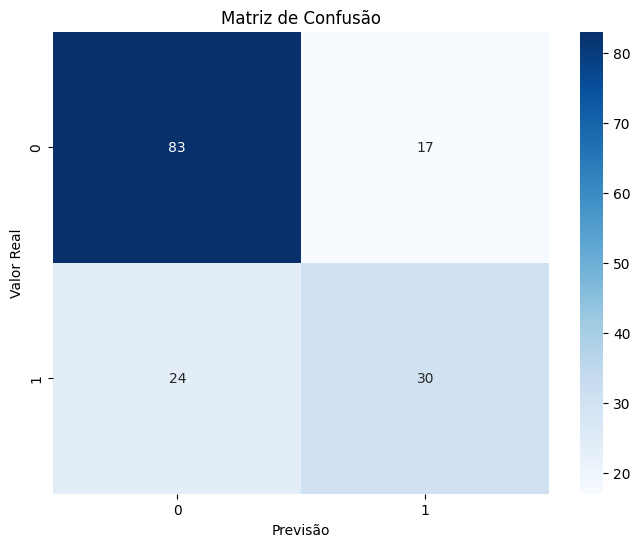

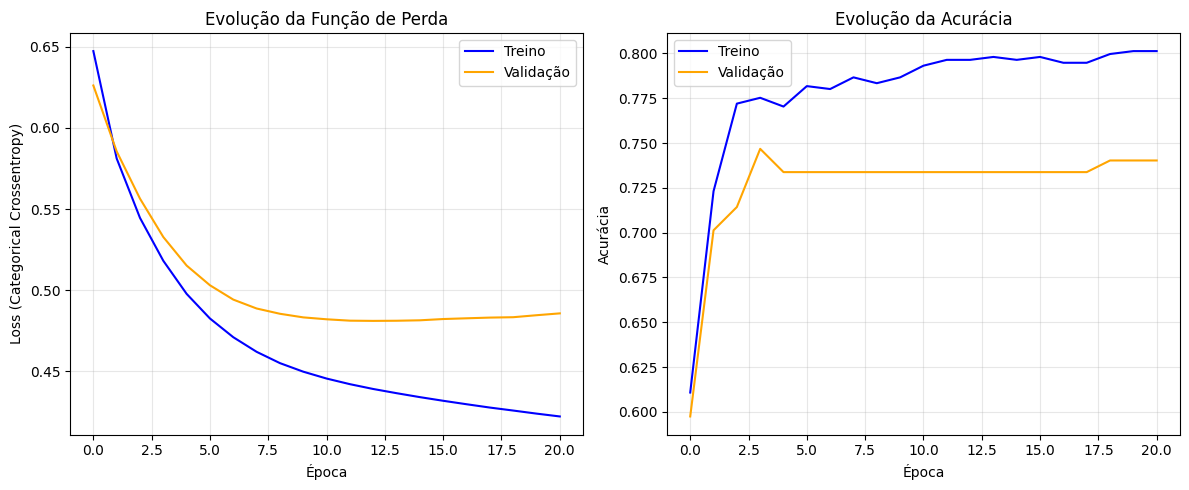

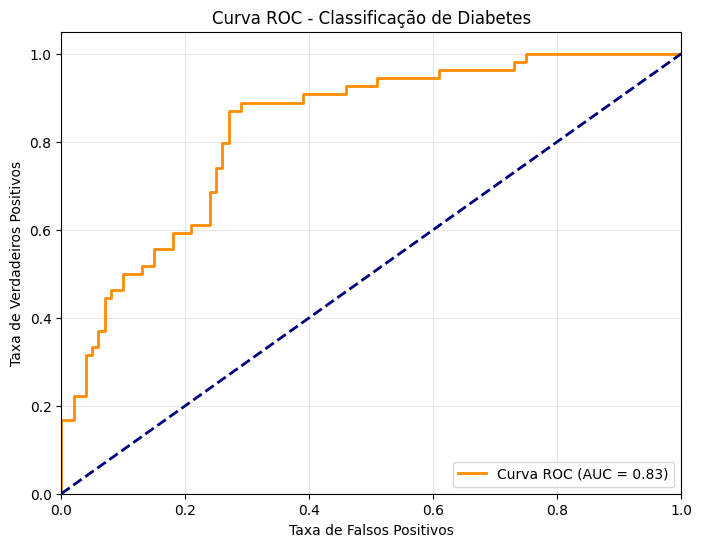

In [13]:
# Modelo base com arquitetura padrão
print("\n🏗️ Criando e treinando modelo base...")
model = create_model(X_train.shape[1], architecture='base')
model.summary()

# Treinar modelo
history = train_model(model, X_train, y_train, X_test, y_test)

# Avaliar modelo
metrics = evaluate_model(model, X_test, y_test, y_test_orig)

# Visualizar resultados
print_metrics(metrics)
plot_training_history(history)
plot_roc_curve(metrics)


🧪 Iniciando experimentos com diferentes arquiteturas...

🏗️ Testando arquitetura: base
Epoch 1/100
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4404 - loss: 0.7229 - val_accuracy: 0.5974 - val_loss: 0.6794
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4404 - loss: 0.7229 - val_accuracy: 0.5974 - val_loss: 0.6794
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6336 - loss: 0.6424 - val_accuracy: 0.6753 - val_loss: 0.6402
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6336 - loss: 0.6424 - val_accuracy: 0.6753 - val_loss: 0.6402
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6743 - loss: 0.6014 - val_accuracy: 0.6688 - val_loss: 0.6177
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6743 - loss: 0.6014 - val_accuracy: 0.6688 - val_loss: 0.6177
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6982 - loss: 0.5731 - val_accuracy: 0.6818 - val_loss: 0.6014
Epoc

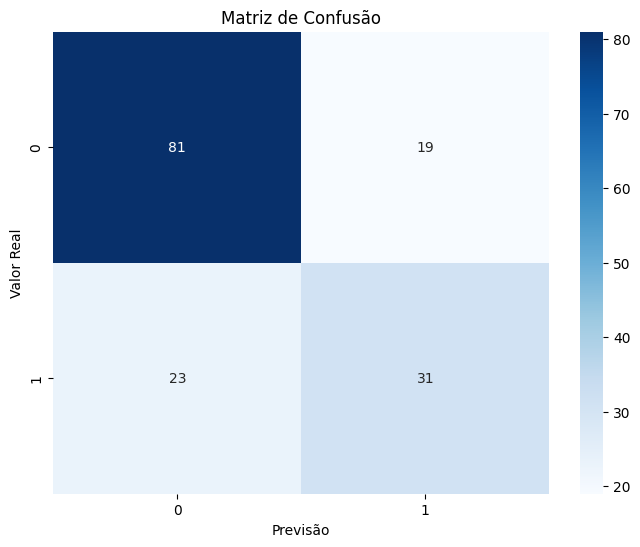

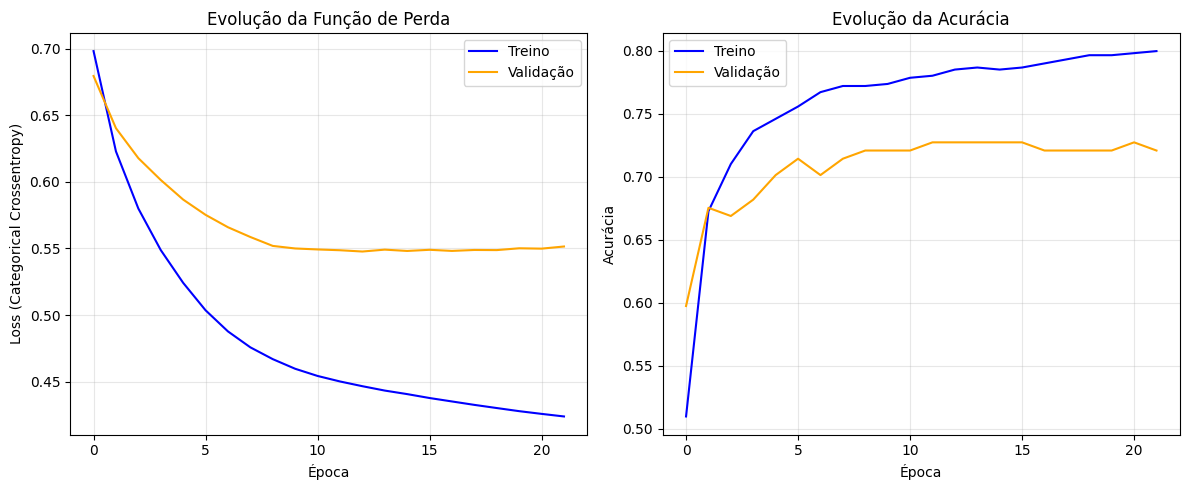

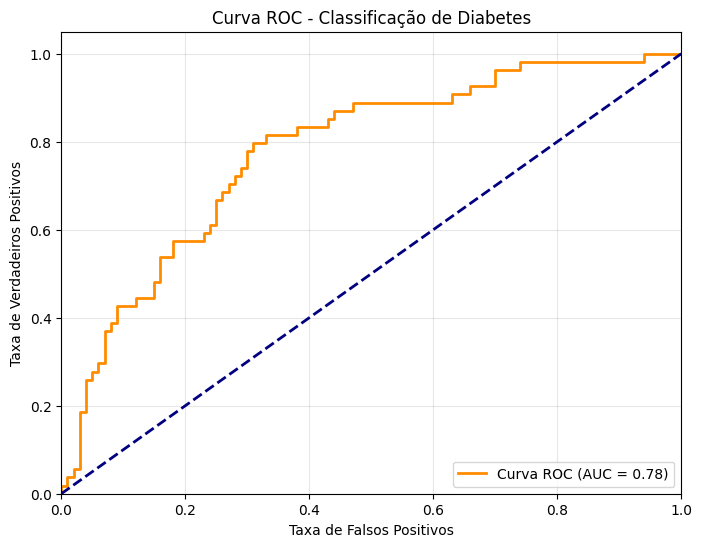


🏗️ Testando arquitetura: deep
Epoch 1/100
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5958 - loss: 0.6677 - val_accuracy: 0.7143 - val_loss: 0.6018
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5958 - loss: 0.6677 - val_accuracy: 0.7143 - val_loss: 0.6018
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7287 - loss: 0.5763 - val_accuracy: 0.7208 - val_loss: 0.5562
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7287 - loss: 0.5763 - val_accuracy: 0.7208 - val_loss: 0.5562
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7303 - loss: 0.5232 - val_accuracy: 0.7273 - val_loss: 0.5284
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7303 - loss: 0.5232 - val_accuracy: 0.7273 - val_loss: 0.5284
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7536 - loss: 0.4938 - val_accuracy: 0.7468 - val_loss: 0.5132
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accurac

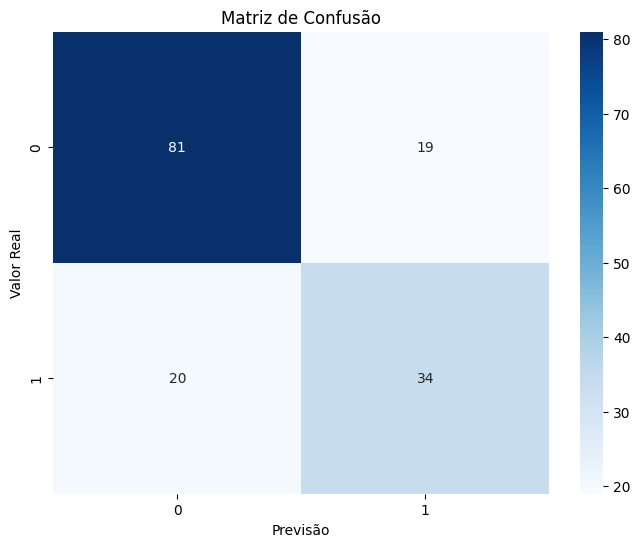

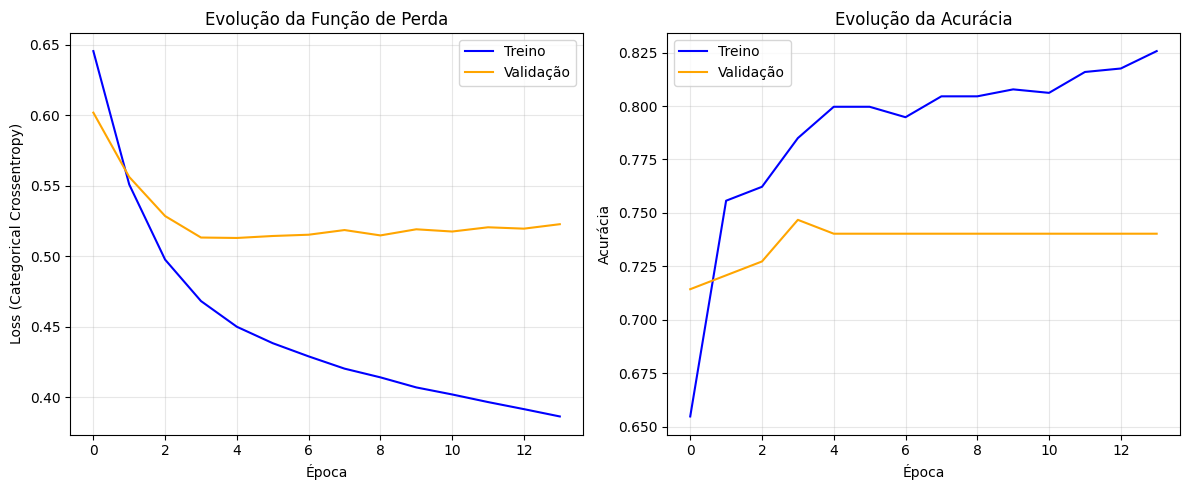

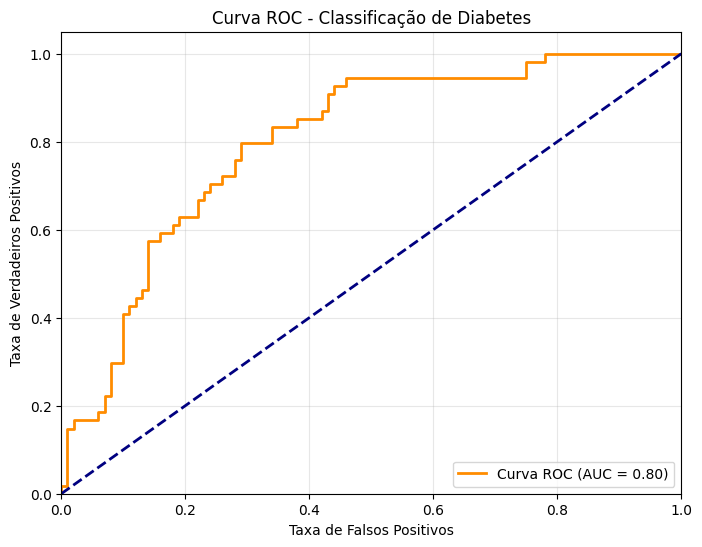


🏗️ Testando arquitetura: wide
Epoch 1/100
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5664 - loss: 0.6713 - val_accuracy: 0.7468 - val_loss: 0.5292
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5664 - loss: 0.6713 - val_accuracy: 0.7468 - val_loss: 0.5292
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7480 - loss: 0.5199 - val_accuracy: 0.7143 - val_loss: 0.4907
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7480 - loss: 0.5199 - val_accuracy: 0.7143 - val_loss: 0.4907
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7678 - loss: 0.4866 - val_accuracy: 0.7403 - val_loss: 0.4789
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7678 - loss: 0.4866 - val_accuracy: 0.7403 - val_loss: 0.4789
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7698 - loss: 0.4750 - val_accuracy: 0.7403 - val_loss: 0.4796
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accurac

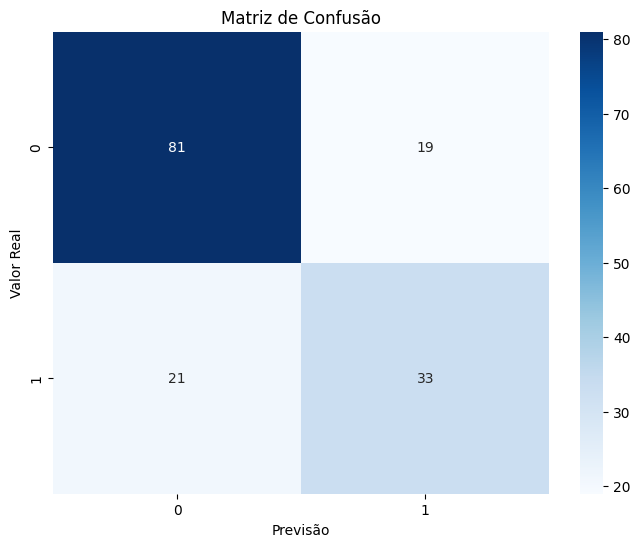

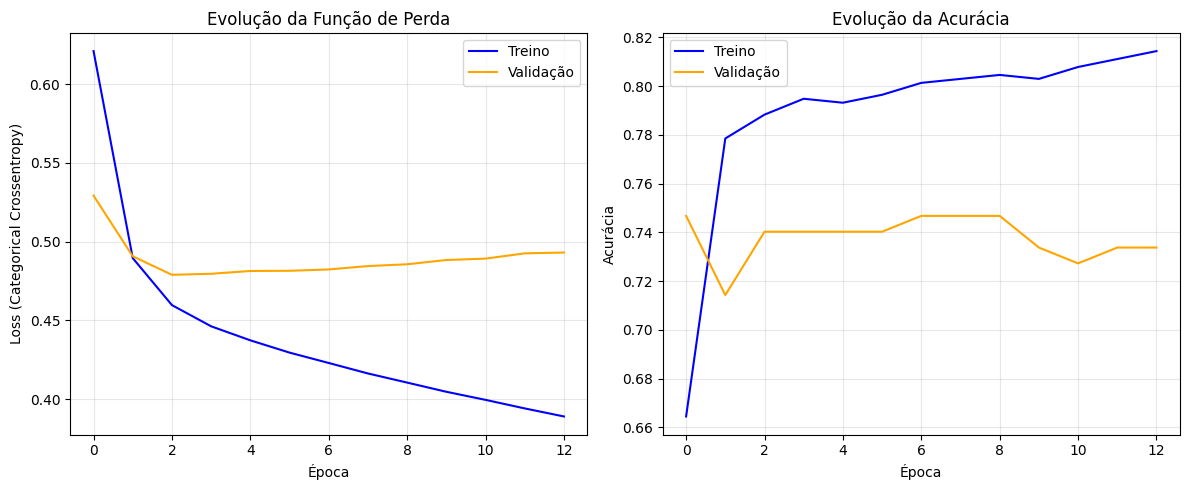

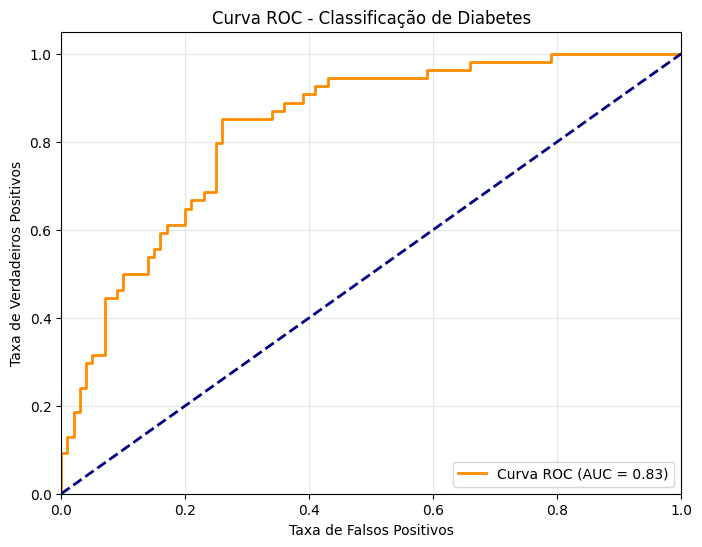


🏗️ Testando arquitetura: regularized
Epoch 1/100
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5569 - loss: 1.2596 - val_accuracy: 0.6494 - val_loss: 1.1180
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5569 - loss: 1.2596 - val_accuracy: 0.6494 - val_loss: 1.1180
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7088 - loss: 1.0785 - val_accuracy: 0.6883 - val_loss: 1.0159
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7088 - loss: 1.0785 - val_accuracy: 0.6883 - val_loss: 1.0159
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7142 - loss: 0.9791 - val_accuracy: 0.7208 - val_loss: 0.9467
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7142 - loss: 0.9791 - val_accuracy: 0.7208 - val_loss: 0.9467
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7441 - loss: 0.9095 - val_accuracy: 0.7273 - val_loss: 0.8912
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - 

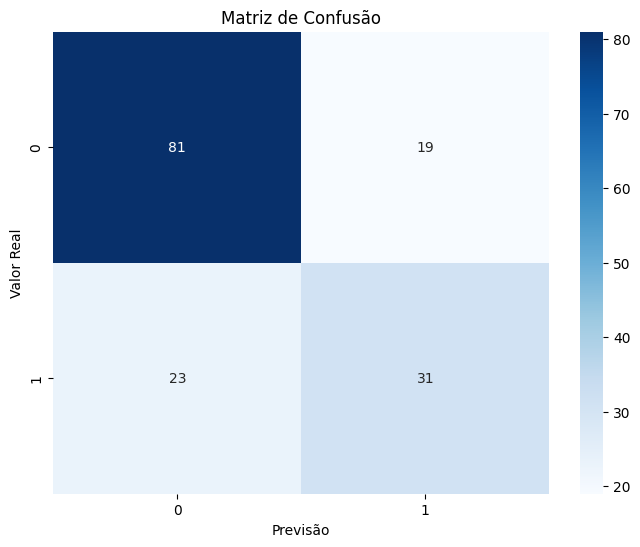

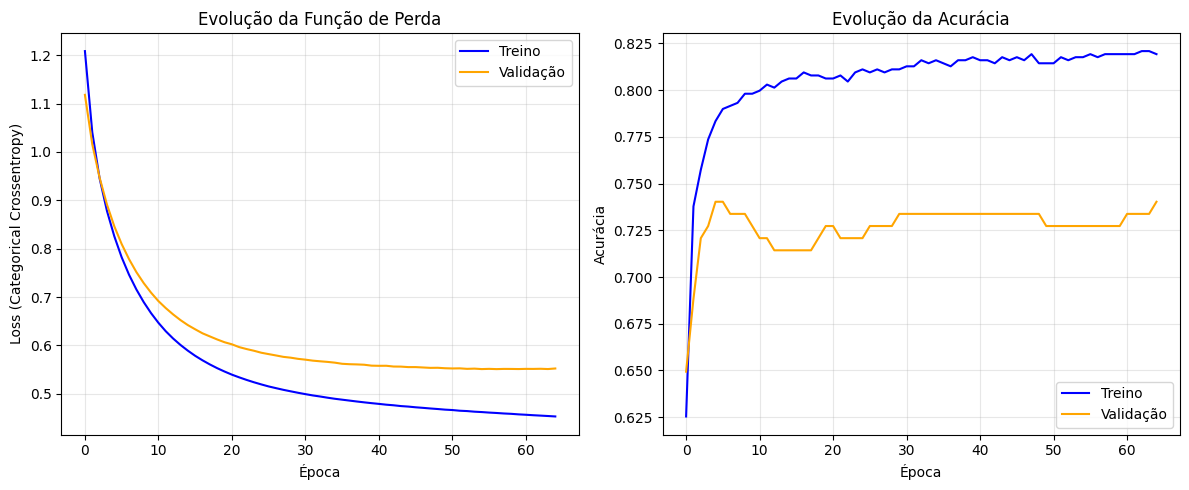

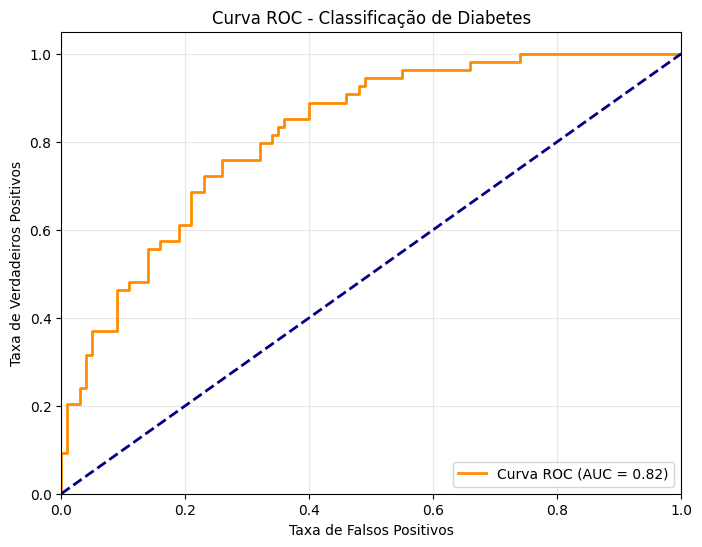


🏗️ Testando arquitetura: dropout
Epoch 1/100
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6249 - loss: 0.6742 - val_accuracy: 0.6688 - val_loss: 0.6075
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6249 - loss: 0.6742 - val_accuracy: 0.6688 - val_loss: 0.6075
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7078 - loss: 0.6002 - val_accuracy: 0.6948 - val_loss: 0.5606
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7078 - loss: 0.6002 - val_accuracy: 0.6948 - val_loss: 0.5606
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7130 - loss: 0.5678 - val_accuracy: 0.7208 - val_loss: 0.5325
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7130 - loss: 0.5678 - val_accuracy: 0.7208 - val_loss: 0.5325
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7347 - loss: 0.5260 - val_accuracy: 0.7143 - val_loss: 0.5174
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accu

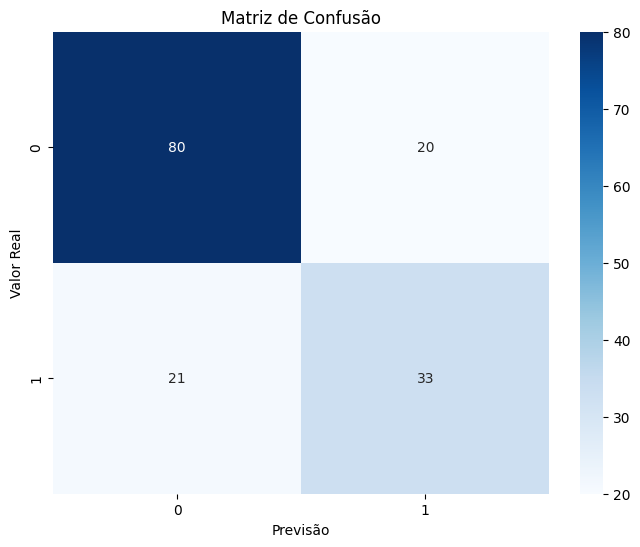

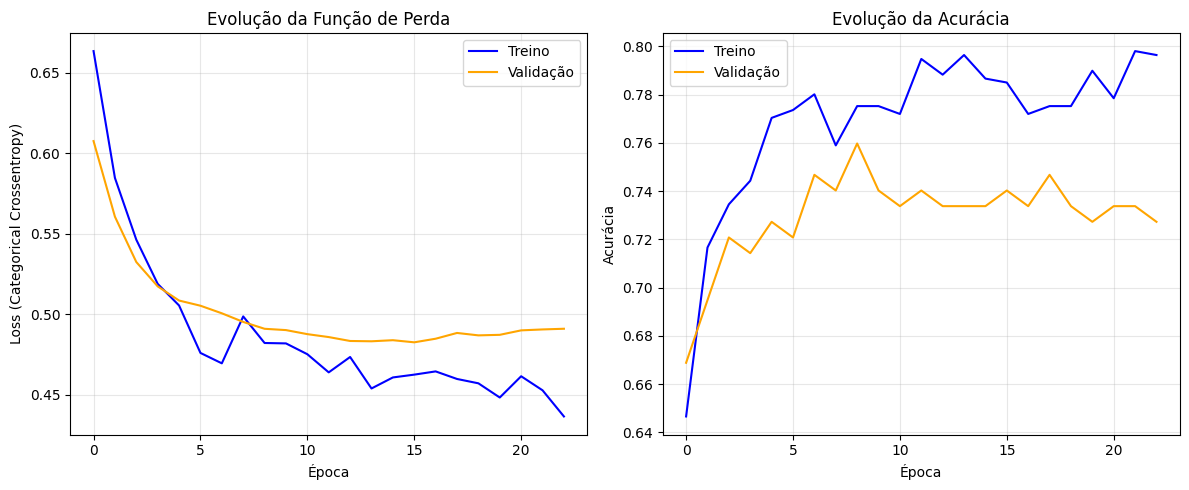

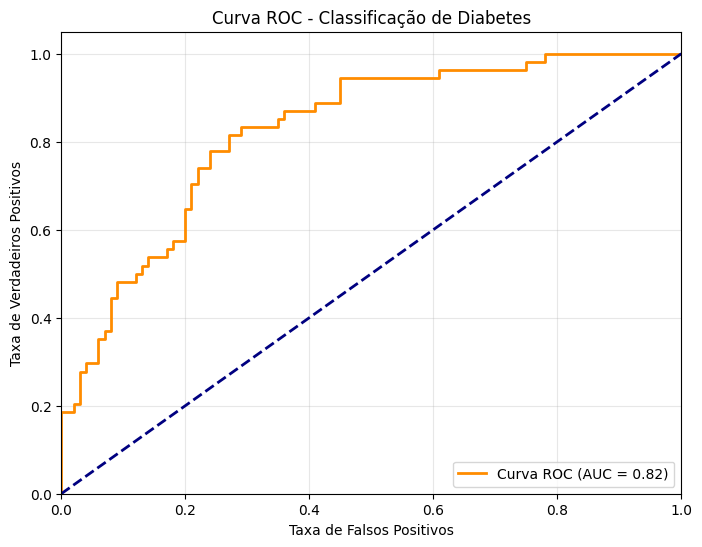

<Figure size 1200x600 with 0 Axes>

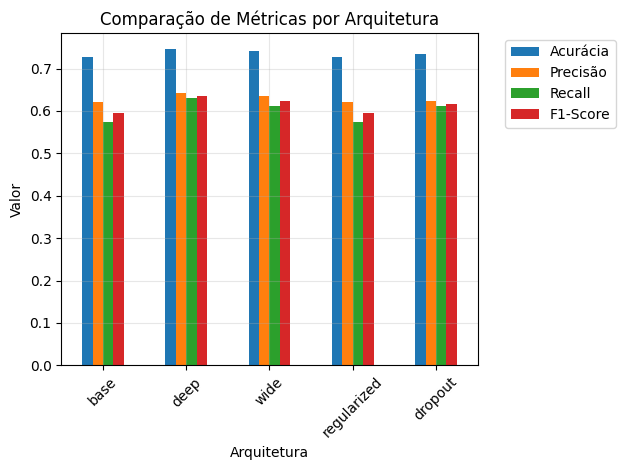

<Figure size 1000x600 with 0 Axes>

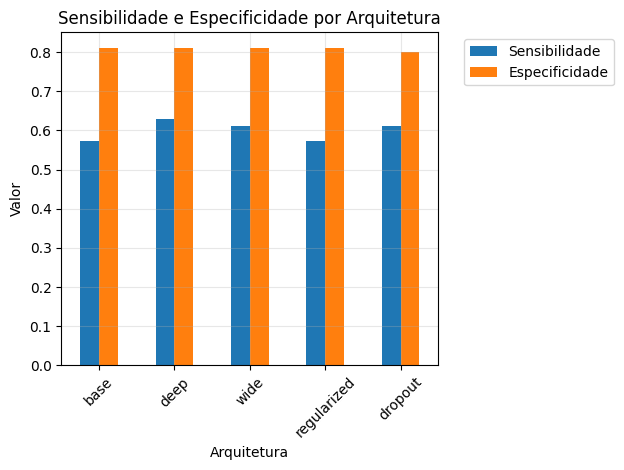


📊 Comparação das Arquiteturas:
             Acurácia  Precisão  Recall  F1-Score  Sensibilidade  \
base           0.7273    0.6200  0.5741    0.5962         0.5741   
deep           0.7468    0.6415  0.6296    0.6355         0.6296   
wide           0.7403    0.6346  0.6111    0.6226         0.6111   
regularized    0.7273    0.6200  0.5741    0.5962         0.5741   
dropout        0.7338    0.6226  0.6111    0.6168         0.6111   

             Especificidade     AUC  
base                   0.81  0.7785  
deep                   0.81  0.8006  
wide                   0.81  0.8309  
regularized            0.81  0.8189  
dropout                0.80  0.8248  


In [14]:
# Experimentar com diferentes arquiteturas
print("\n🧪 Iniciando experimentos com diferentes arquiteturas...")
results_df = experiment_architectures(X_train, X_test, y_train, y_test, y_test_orig)

print("\n📊 Comparação das Arquiteturas:")
print(results_df)

## 🎯 Conclusão: Redes Neurais para Classificação de Diabetes

### 📊 Avaliação das Arquiteturas de Redes Neurais

Os experimentos com diferentes arquiteturas nos permitiram identificar padrões importantes na classificação de diabetes:

| Arquitetura | Acurácia | Precisão | Recall | AUC | Especificidade |
|-------------|----------|-----------|--------|-----|----------------|
| **Base** | 72.73% | 62.00% | 57.41% | 0.779 | 81.00% |
| **Deep** | 74.68% | 64.15% | 62.96% | 0.801 | 81.00% |
| **Dropout** | 73.38% | 62.26% | 61.11% | 0.825 | 80.00% |
| **Regularized** | 72.73% | 62.00% | 57.41% | 0.819 | 81.00% |
| **Wide** | 74.03% | 63.46% | 61.11% | 0.831 | 81.00% |

### 🧠 Principais Insights dos Resultados

1. **Performance das Arquiteturas**
   - A arquitetura Deep alcançou a melhor acurácia (74.68%) e precisão (64.15%)
   - A arquitetura Wide demonstrou boa performance em AUC (0.831), indicando melhor capacidade de discriminação
   - Todas as arquiteturas mantiveram uma especificidade consistente (~81%)

2. **Equilíbrio entre Métricas**
   - Sensibilidade (Recall) mais baixa que especificidade em todas as arquiteturas
   - Trade-off entre verdadeiros positivos e falsos positivos evidente nos resultados
   - AUC variando entre 0.779 e 0.831, indicando capacidade discriminativa moderada

3. **Desafios Observados**
   - Performance moderada em geral (acurácias entre 72-75%)
   - Dificuldade em manter alto recall sem comprometer a precisão
   - Consistência na especificidade sugere melhor detecção de casos negativos

### 🏥 Implicações Clínicas

1. **Utilidade como Ferramenta de Triagem**
   - Melhor adequação como ferramenta de apoio inicial
   - Alta especificidade (>80%) sugere confiabilidade em resultados negativos
   - Necessidade de confirmação laboratorial para casos positivos

2. **Limitações na Prática Clínica**
   - Sensibilidade moderada (57-63%) indica risco de falsos negativos
   - Precisão em torno de 62-64% sugere necessidade de testes confirmatórios
   - Performance consistente com literatura para predição de diabetes usando apenas dados clínicos

### 🔍 Análise das Arquiteturas

1. **Base**
   - Acurácia mais baixa (72.73%)
   - AUC de 0.779, indicando menor capacidade discriminativa
   - Sensibilidade e especificidade equilibradas
   - Baixa precisão (62.00%)

2. **Deep (Melhor Acurácia)**
   - Acurácia: 74.68%
   - Melhor equilíbrio entre precisão (64.15%) e recall (62.96%)
   - AUC de 0.801 indica boa capacidade discriminativa

3. **Dropout**
   - Performance intermediária (73.38% acurácia)
   - Bom AUC (0.825)
   - Ligeira redução na especificidade (80%)

4. **Regularized**
   - Performance similar (72.73% acurácia)
   - Regularized com melhor AUC (0.819)
   - Sensibilidade e especificidade equilibradas
   - Menor recall (57.41%) entre todas arquiteturas

5. **Wide (Melhor AUC)**
   - AUC mais alto (0.831)
   - Boa acurácia (74.03%)
   - Mantém bom equilíbrio entre métricas


### 🚀 Recomendações para Melhorias

1. **Otimizações Técnicas**
   - Explorar técnicas de balanceamento de dados
   - Investigar feature engineering mais sofisticado
   - Considerar ensemble methods para melhorar performance

2. **Pré-processamento de Dados**
   - Tratamento mais robusto de valores zerados
   - Normalização adaptativa por característica
   - Análise de outliers mais detalhada

3. **Extensões do Modelo**
   - Incorporar dados longitudinais quando disponíveis
   - Adicionar variáveis de estilo de vida e histórico familiar
   - Desenvolver sistema de pontuação de risco gradual

### 📈 Perspectivas Futuras

1. **Desenvolvimento do Modelo**
   - Implementar validação cruzada k-fold
   - Explorar arquiteturas híbridas
   - Adicionar análise de importância de features

2. **Aplicação Prática**
   - Desenvolver interface para uso clínico
   - Integrar com sistemas de prontuário eletrônico
   - Estabelecer protocolos de atualização do modelo

3. **Validação Externa**
   - Testar em populações diversas
   - Comparar com outros métodos de triagem
   - Realizar estudos prospectivos

Este trabalho demonstra o potencial e as limitações das redes neurais na previsão de diabetes. Com acurácias entre 72-75% e AUC até 0.831, os modelos mostram utilidade como ferramentas de triagem inicial, mas destacam a necessidade de uso em conjunto com avaliação clínica tradicional. A arquitetura Deep apresentou os melhores resultados gerais, enquanto a Wide mostrou melhor capacidade discriminativa através do AUC. As limitações observadas sugerem que melhorias futuras devem focar em técnicas de pré-processamento mais sofisticadas e possível incorporação de dados adicionais relevantes.